Using Selenium to achieve automated Google search to scrape lyrics online.

Acknowledgment

This Python notebook was made by Solomon Kit Shing Ho (kshingho@connect.hku.hk) in October 2023.

Prepared exclusively for BA(HDT) coding session "Tech Thursday: Code & Connect".

Last Updated: 10 October, 2023

This Python notebook is then further adapted by Wong Yu, Cole (cwy1013@connect.hku.hk) in October 2023 for research purposes.

Any block that isn't importing or Selenium is written by Wong Yu, Cole.

Last Updated: 19 October, 2023

<h1>Sam-Sung: An Introductory Historical Analysis on Sam Hui's Lyrical Styles</h1>

<h2>Topic Synopsis</h2>
Sam Hui was an influential singer, composer, and actor, who is often dubbed the 'God of Song' in Cantopop. 

However, across his wide catalog of songs, both written and performed, there are obvious stylistic differences that while obvious to listeners, may be difficult to articulate with precision. For example, while one can tell that Sam shifted to more romantic songs during the 1980s, it is still difficult to contrast it with his earlier romance songs; with at least 101 songs performed (Universal Music Ltd., 2011) and more written by him, listeners may struggle to grasp details of his musical style since his debut in the 1970s.

Therefore, I hope to contribute to this discussion by attempting to provide quantitative evidences on Cantonese songs published directly under his name up until 2007 to support conclusions that move past personal impressions, and allow for more empirical understandings on this monumental figure in Hong Kong history.

<h2>Choices of Tool</h2>

<h3>BeautifulSoup</h3>

I will use BeautifulSoup to scrap a list of songs for Selenium to process on.

<h3>Selenium</h3>

I will mainly be using Selenium as it allows me to scrap the internet across various websites for lyrics.


<h3>NLTK: Natural Language Toolkit</h3>

I will also be using NLTK to clean up the lyrics collected as they may be annotated with unwanted characters that hinder machine comprehension.

<h3>ChatGPT</h3>

Finally, I will feed each song's lyrics into ChatGPT for preliminary thematic categorisation.

In [ ]:
!pip install requests requests_html selenium beautifulsoup4 tqdm

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import csv
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException

In [18]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from requests_html import HTMLSession
import urllib.parse
import requests
import pandas as pd
import re

from csv import writer

<h2>Preparing his Musical Catalog</h2>

With such an extensive list of musical compositions, the first part would be to gather a comprehensive list of songs related to him.

<h3>Data Curation</h3>
I will first extract a basic list of songs from the relatively clean Wikipedia page 許冠傑音樂專輯列表 (https://zh.wikipedia.org/wiki/許冠傑音樂專輯列表). Due to time constraints this will be my only reference, and songs beyond this list will not be considered within the project scope.

Due to time contraints, I will also omit English songs despite them appearing on the wikipedia page too, as they are largely popular Western songs sung by Sam rather than compositions curated for him. However, relevant data, albeit incomplete, will still be available upon request.

Then, I will scrap the more detailed webpage (https://mojim.com/ush101187-A2.htm) for additional information, and make manual adjustments to ensure consistency. Any extra songs picked up here will be stored in a seperate unorganised database, and can also be provided upon request.

Note that I explicitly will not include songs Sam Hui composed for Rick Hui, his brother, and others due to time constraints, but future researchers may look into them at their own discretion.



In [10]:
url= "https://zh.wikipedia.org/wiki/許冠傑音樂專輯列表"
webpage1 = requests.get(url)
soup1 = BeautifulSoup(webpage1.content, 'html.parser')

lists = soup1.find_all('table', class_='wikitable')

In [102]:
wiki = [] #We will now scrap the Wikipedia page with manual input (don't rerun!)
tab = 0
for i in lists:
    j = i.find_all("tr")
    for k in j:
        Date = k.find("th")
        DateT = Date.get_text()
        if DateT != "出版日期\n":
            DateS = DateT.split('年')
            Year = int(DateS[0])
            #print(Year)

            t = k.find_all("td")
            AlbumName = t[0].get_text().strip("\n ")
            #print(AlbumName)

            l = k.find_all("li") #Extracting all the song names out

            AlbumType = "Full"
            if tab == 2:
                if len(l) == 1:
                    AlbumType = "Single"
                else:
                    AlbumType = "Extended Play"
            #print(AlbumType)

            RecordLabelT = t[1].get_text().strip("\n").split("、")
            RecordLabels = ";".join(RecordLabelT)
            #print(RecordLabels)

            for s in l:
                small = s.find("small")
                Artists = "許冠傑"
                Medley = ""
                if not small:
                    SongP = s.get_text().strip("）\n").split('（')
                    SongName = SongP[0]
                    #print(SongName)
                    
                    if len(SongP) > 1:
                        if SongP[1] == "音樂":
                            SongName = SongName + '(' + SongP[1] + ')'
                            Artists = "Instrumental"
                        else:
                            if SongP[0] == "鬼馬大家樂":
                                Medley = ";".join(SongP[1].split("、"))
                            else:
                                SongName = SongName + '(' + SongP[1] + ')'  
                                #print(SongName)   
                else:
                    SongP = s.get_text().strip("）\n").split('（')
                    SongName = SongP[0].replace(small.get_text(),"")
                    SongName = SongName[:-1]
                    #print(SongName)
                    if SongName == "繼續微笑" or SongName == "'04 祝福你" or SongName == "誰在你心裡":
                        Artists += ";Sam's Angels,2004"
                    elif SongName == "鐘聲響起":   
                          Artists += ";許懷欣(Rap);許懷谷(Rap)"        
                    else:
                        print(SongName, end=":")
                        print(Artists, end=";")
                        print(small.get_text().strip("()（）\n "), end=";")
                        Artists = input(small.get_text())
                        print("")
                
                wiki.append({
                    "Year": Year,
                    "Album Names": AlbumName,
                    "Album Type": AlbumType,
                    "Record Label(s)": RecordLabels,
                    "Song Name": SongName,
                    "Medley": Medley,
                    "Artist(s)": Artists,
                    "Composer(s)": "",
                    "Lyricist(s)": ""
                })
            #print("\n")
        else:
            print("\nBegin parsing table...\n")
    tab += 1


Begin parsing table...

我愛你:許冠傑;陳秋霞合唱;
無敵是愛:許冠傑;甄妮合唱;
沉默是金:許冠傑;獨唱版本;
沉默是金:許冠傑;張國榮合唱;
我未驚過:許冠傑;張國榮合唱;

Begin parsing table...


Begin parsing table...

Top Secret(廣東/英語版):許冠傑;許冠傑+山田邦子;
Top Secret(日語版):許冠傑;山田邦子;
最緊要好玩 (攪笑版本):許冠傑;許冠傑+徐克+泰迪羅賓;


In [106]:
wiki #You may run this to display the entire Wikipedia list

[{'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '雙星情歌',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '鬼馬雙星',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '甜蜜伴侶',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '無情夜冷風',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '一水隔天涯／愛你三百六十年',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Ye

In [97]:
import copy

In [168]:
moji = copy.deepcopy(wiki) #This will be the table which we work on for scraping on mojim.com

In [107]:
moji

[{'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '雙星情歌',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '鬼馬雙星',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '甜蜜伴侶',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '無情夜冷風',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '一水隔天涯／愛你三百六十年',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  'Lyricist(s)': ''},
 {'Ye

In [119]:
url= "https://mojim.com/ush101187-A2.htm"
webpage2 = requests.get(url)
soup2 = BeautifulSoup(webpage2.content, 'html.parser')

lists = soup2.find('dl', class_='ha0')

In [120]:
lists

<dl class="ha0">
<dd class="hb9">許冠傑( Samuel Hui )【 676 songs in total 】</dd>
<dd class="hb0">許冠傑（英文：Samuel Hui，1948年9月6日－），暱稱「阿Sam」，生於廣東廣州，籍貫廣東番禺（今廣州市），自70年代起以通俗廣東Lyrics譜下多首樂章，開創香港粵語流行曲的潮流，在香港樂壇被稱為「歌神」、「香港樂壇祖師」和「廣東歌鼻祖」。<br/><br/>許冠傑的父親許世昌是業餘中樂家﹐母親李倩雲曾在廣州唱粵曲。許冠傑兩歲的時候，跟父親同家人從大陸移民到香港，定居在鑽石山，後搬到蘇屋村，許冠傑亦進入中學（聖芳濟書院（初高中））。1964年他和朋友組成「harmonicks樂隊」，彈低音結他與當主音歌手。曾在酒店及麗的「樂韻之聲」表演。1965年「harmonicks」解散，他即加入「bar six」，在總統酒店地牢的fire cracker酒吧演唱。1966年bar six改名為lotus「蓮花樂隊」，成員包括張浚英（鼓手）、蘇雄（低音結他）、李松江（旋律結他）、周華年（主音結他），許冠傑任主音歌手，後為鑽石唱片公司灌錄了首張細碟「just a little」和「i'm be waiting」。但因後來與無線簽約，不顧經理人lal dayaram的反對而被唱片公司雪藏。1967年，lotus開始為無線主持每週五次的青年人節目「star show」「星報青年節目」，大受歡迎。樂隊被迫解散後，開始獨立發展。從英華書院預科畢業後，在1969年，他成功考進港大心理學系，並於1971年完成課程，同年12月30日與拍拖五年的美菲混血兒女友在美國加州聖地亞哥市的教堂結婚。<br/><br/>1971年簽約寶麗金唱片公司，推出細碟《April Lady》及《Time of the Season》等。<br/><br/>1972年與許冠文在香港無線電視（TVB）《雙星報喜》節目中，節目上以一曲《鐵塔凌雲》，與TVB電視劇主題曲一起成為香港粵語流行曲的「開山祖師」，並有「歌神」之稱。<br/><br/>1976年9月3日，他的第一個兒子許懷欣出世﹐1978年2月14日再任爸爸﹐第二個兒子改名許懷谷。<br/><br/>許冠傑的歌曲部份改編自西方流行音樂的旋律，但亦有不少為原創。70年代

In [169]:
def SearchMoji(SongName, Composers, Lyricists):
    Place = 0
    Flag = False
    while Place < len(moji):
        if moji[Place]["Song Name"] == SongName:
            if Composers != "\u3000":
                moji[Place]["Composer(s)"] = Composers 
            if Lyricists != "\u3000": 
                moji[Place]["Lyricist(s)"] = Lyricists
            Flag = True
        Place += 1
    if Flag:
        return 69
    else: 
        return -69
            
    

In [170]:
mojim = [] #This extra list is to store new items from mojim.com for manual input
hb2 = lists.find_all("dd", class_ = "hb2")
hb3 = lists.find_all("dd", class_ = "hb3")

for hbb in hb2:
    SongName = hbb.find("a").get_text()

    Composers = ";".join(hbb.find("span", class_ = "hc3").get_text().split('/'))
    Lyricists = ";".join(hbb.find("span", class_ = "hc2").get_text().split('/'))
    print(SongName, Composers, Lyricists)
    if SearchMoji(SongName, Composers, Lyricists) == -69:
        Year = 0
        YearT = hbb.find("span", class_ = "hc4").get_text().split('-')[0]
        if YearT != "　":
            Year = int(YearT)
        mojim.append({
            "Year": Year,
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": SongName,
            "Medley": "",
            "Artist(s)": "許冠傑",
            "Composer(s)": Composers,
            "Lyricist(s)": Lyricists
        })

for hbb in hb3:
    SongName = hbb.find("a").get_text()

    Composers = ";".join(hbb.find("span", class_ = "hc3").get_text().split('/'))
    Lyricists = ";".join(hbb.find("span", class_ = "hc2").get_text().split('/'))
    print(SongName, Composers, Lyricists)
    if SearchMoji(SongName, Composers, Lyricists) == -69:
        Year = 0
        YearT = hbb.find("span", class_ = "hc4").get_text().split('-')[0]
        if YearT != "　":
            Year = int(YearT)
        mojim.append({
            "Year": Year,
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": SongName,
            "Medley": "",
            "Artist(s)": "許冠傑",
            "Composer(s)": Composers,
            "Lyricist(s)": Lyricists
        })

04'祝福你(& His Angels) 許冠傑 許冠傑
A Spaceman Came Travelling 　 　
Christina 徐日勤 林振強
It's Gonna Change 　 　
Just A Little 　 　
Medley 　 　
Medley:咪當我老襯/佛跳牆/錢會繼續嚟 J.Leiber-M.Stoller 許冠傑;黎彼得
Medley:最佳拍檔/跟佢做個Friend/揾嘢做 許冠傑 許冠傑
Medley:為你/這一曲送給您/杯酒當歌 許冠傑 詹惠風
One Tin Soldier 　 　
Pretty woman R.Orbison;J.Melson;R.B.Rush 許冠傑
Radio好知己 　 　
Radio好知己 Mike Hawker;Ivor Raymonde 林振強
Sexy Girl 筒美京平 林敏驄
Streets Of London 　 　
Time Of The Season 　 　
Yesterday When I Was Young 　 　
忍 許冠傑 許冠傑;黎彼得
人辦 許冠傑 許冠傑;黎彼得
今宵 許冠傑 許冠傑;詹惠風
印象 許冠傑 許冠傑;黎彼得
印象 許冠傑 許冠傑;黎彼得
印象 許冠傑 許冠傑;黎彼得
印象 許冠傑 許冠傑;黎彼得
快樂 許冠傑 許冠傑
我問 馮添枝 黃霑
夜雨 許冠英 許冠英
往事 Trpper-Bennett 許冠傑;黎彼得
泡影 梁樂聲 鄭國江
星夜 　 　
春夢 許冠傑 許冠傑;黎彼得
春夢 許冠傑 許冠傑;黎彼得
春夢 許冠傑 許冠傑;黎彼得
昨天 許冠傑 許冠傑
為你 許冠傑 詹惠風
為妳 許冠傑 詹惠風
珍惜 許冠傑 許冠傑
珍惜 許冠傑 許冠傑
珍惜 許冠傑 許冠傑
紙船 許冠傑 許冠傑
紙船 許冠傑 許冠傑
紙船 許冠傑 許冠傑
紙船 許冠傑 許冠傑
傀儡 許冠傑 許冠傑;黎彼得
傀儡 許冠傑 許冠傑;黎彼得
陽光 許冠傑 許冠傑;黎彼得
飲勝 許冠傑 許冠傑;黎彼得
嗒糖 　 　
愛韻 Chandler;Mcknedry 許冠傑
親情 　 　
懷傷 太極 林敏驄
靈魂 　 　
不要問 單立文 林夕
太空舞(「賣身契」棉) 許冠傑 　
心思思 Terry Britten；Lynsey de Paul 林振強
心思思 Terry Britten;Lynsey De

In [159]:
Place = 0 #Correcting an inconsistency I found on the way
while Place < len(moji):
    if moji[Place]["Song Name"] == '宇宙無限 Instrumental':
        moji[Place]["Artist(s)"] = 'Instrumental'
    Place += 1

In [171]:
moji #Note how our dataset is still incomplete

[{'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '雙星情歌',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '許冠傑',
  'Lyricist(s)': '許冠傑'},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '鬼馬雙星',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '許冠傑',
  'Lyricist(s)': '許冠傑'},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '甜蜜伴侶',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '許冠英',
  'Lyricist(s)': '許冠英'},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '無情夜冷風',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '許冠英',
  'Lyricist(s)': '許冠英'},
 {'Year': 1974,
  'Album Names': '鬼馬雙星',
  'Album Type': 'Full',
  'Record Label(s)': '寶麗多',
  'Song Name': '一水隔天涯／愛你三百六十年',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '',
  '

In [172]:
mojim #As you can see, a lot of the 'unmarked' songs are trivial

[{'Year': 2004,
  'Album Names': '',
  'Album Type': '',
  'Record Label(s)': '',
  'Song Name': "04'祝福你(& His Angels)",
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '許冠傑',
  'Lyricist(s)': '許冠傑'},
 {'Year': 2003,
  'Album Names': '',
  'Album Type': '',
  'Record Label(s)': '',
  'Song Name': 'Just A Little',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '\u3000',
  'Lyricist(s)': '\u3000'},
 {'Year': 2004,
  'Album Names': '',
  'Album Type': '',
  'Record Label(s)': '',
  'Song Name': 'Medley',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': '\u3000',
  'Lyricist(s)': '\u3000'},
 {'Year': 2003,
  'Album Names': '',
  'Album Type': '',
  'Record Label(s)': '',
  'Song Name': 'Medley:咪當我老襯/佛跳牆/錢會繼續嚟',
  'Medley': '',
  'Artist(s)': '許冠傑',
  'Composer(s)': 'J.Leiber-M.Stoller',
  'Lyricist(s)': '許冠傑;黎彼得'},
 {'Year': 2003,
  'Album Names': '',
  'Album Type': '',
  'Record Label(s)': '',
  'Song Name': 'Medley:最佳拍檔/跟佢做個Friend/揾嘢做',
  'Medley': '',
  'Artist(s)'

In [177]:
mojimTBC = [] #We will now filter out the unwanted duplicates
for i in mojim:
    if input(i["Song Name"]) == "1":
        print("Adding " + i["Song Name"])
        mojimTBC.append({
            "Year": i["Year"],
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": i["Song Name"],
            "Medley": "",
            "Artist(s)": i["Artist(s)"],
            "Composer(s)": i["Composer(s)"],
            "Lyricist(s)": i["Lyricist(s)"]
        })

Adding Just A Little
Adding Medley
Adding Medley:咪當我老襯/佛跳牆/錢會繼續嚟
Adding Medley:最佳拍檔/跟佢做個Friend/揾嘢做
Adding Medley:為你/這一曲送給您/杯酒當歌
Adding One Tin Soldier
Adding 嗒糖
Adding 親情
Adding 靈魂
Adding 代表作
Adding 橫財夢(Remix Version)
Adding 擦鞋仔(Remix)
Adding 好好先生
Adding 街知巷聞
Adding 馬路小英雄(& 張艾嘉)
Adding 創新賀年歌
Adding 愛得好緊要
Adding Danger Zone
Adding Johnny B.Goode
Adding Medley(十個女仔/Pretty Woman/瑪莉我好鍾意您/尖沙咀Suzie/日本娃娃)
Adding Medley:學生哥/梨渦淺笑/世事如棋/天才白癡夢
Adding Medley:柔情淚/雙星情歌
Adding You Make Me Shine
Adding 組曲(世事如棋/相思萬千重/斷腸夢/知音夢裏尋/夜半輕私語/梨渦淺笑)
Adding 露骨
Adding 天地人
Adding 心思思(Remix Version)
Adding 一廂情願
Adding 小李飛刀
Adding 半斤八兩(創業與家版)
Adding 皇者之風
Adding 浪漫情懷
Adding 最好地方
Adding 簡單真誠
Adding 何必再遲疑
Adding 難忘往日情
Adding 第一首中文Lyrics


In [180]:
#After filtering the above list for 20 minutes, I decided to save everything first
mojimTBCpd = pd.DataFrame(mojimTBC)
print(mojimTBCpd)
mojimTBCpd.to_csv('SamHui-Catalog-ToBeAdded.csv',  encoding='utf_8_sig')

    Year Album Names Album Type Record Label(s)  \
0   2003                                          
1   2004                                          
2   2003                                          
3   2003                                          
4   2003                                          
5   2003                                          
6   2003                                          
7   2003                                          
8   2003                                          
9   2003                                          
10  1988                                          
11  2003                                          
12  2003                                          
13  2003                                          
14     0                                          
15  2003                                          
16  2004                                          
17  2003                                          
18  2003                       

In [181]:
mojipd = pd.DataFrame(moji)
print(mojipd)
mojipd.to_csv('SamHui-Catalog-List-Step2.csv',  encoding='utf_8_sig')

     Year Album Names     Album Type Record Label(s)      Song Name Medley  \
0    1974        鬼馬雙星           Full             寶麗多           雙星情歌          
1    1974        鬼馬雙星           Full             寶麗多           鬼馬雙星          
2    1974        鬼馬雙星           Full             寶麗多           甜蜜伴侶          
3    1974        鬼馬雙星           Full             寶麗多          無情夜冷風          
4    1974        鬼馬雙星           Full             寶麗多  一水隔天涯／愛你三百六十年          
..    ...         ...            ...             ...            ...    ...   
363  1986        宇宙無限  Extended Play             新藝寶       Radio好知己          
364  1989  珍惜.....往日情  Extended Play             新藝寶       往日情(現場版)          
365  1989  珍惜.....往日情  Extended Play             新藝寶      兩個世界(現場版)          
366  1989  珍惜.....往日情  Extended Play             新藝寶           沉默是金          
367  1989  珍惜.....往日情  Extended Play             新藝寶             珍惜          

    Artist(s)                  Composer(s) Lyricist(s)  
0     

In [182]:
wikipd = pd.DataFrame(wiki)
print(wikipd)
wikipd.to_csv('SamHui-Catalog-List-Step1.csv',  encoding='utf_8_sig')

     Year Album Names     Album Type Record Label(s)      Song Name Medley  \
0    1974        鬼馬雙星           Full             寶麗多           雙星情歌          
1    1974        鬼馬雙星           Full             寶麗多           鬼馬雙星          
2    1974        鬼馬雙星           Full             寶麗多           甜蜜伴侶          
3    1974        鬼馬雙星           Full             寶麗多          無情夜冷風          
4    1974        鬼馬雙星           Full             寶麗多  一水隔天涯／愛你三百六十年          
..    ...         ...            ...             ...            ...    ...   
363  1986        宇宙無限  Extended Play             新藝寶       Radio好知己          
364  1989  珍惜.....往日情  Extended Play             新藝寶       往日情(現場版)          
365  1989  珍惜.....往日情  Extended Play             新藝寶      兩個世界(現場版)          
366  1989  珍惜.....往日情  Extended Play             新藝寶           沉默是金          
367  1989  珍惜.....往日情  Extended Play             新藝寶             珍惜          

    Artist(s) Composer(s) Lyricist(s)  
0         許冠傑          

<h3>Manual Processing</h3>

After some manual data processing on a spreadsheet view of the .csv files, I have finally finished preparing his music catalog based on Wikipedia.

Please refer to "Data Curation" for detailed explanation on what I have done.

In [194]:
lcl = [] #This is the final list
with open('SamHui-Catalog-List.csv', 'r',encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        lcl.append({
            "Year": row[1],
            "Album Names": row[2],
            "Album Type": row[3],
            "Record Label(s)": row[4],
            "Song Name": row[5],
            "Medley": row[6],
            "Artist(s)": row[7],
            "Composer(s)": row[8],
            "Lyricist(s)": row[9]
        })
lcl.pop(0)
print(lcl)

[{'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '雙星情歌', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '鬼馬雙星', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '甜蜜伴侶', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠英', 'Lyricist(s)': '許冠英'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '無情夜冷風', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠英', 'Lyricist(s)': '許冠英'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '一水隔天涯／愛你三百六十年', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '于粦;川口真', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album

In [195]:
cl = pd.DataFrame(lcl)

In [196]:
cl #The table is shown as follows

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s)
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,,許冠傑,于粦;川口真,許冠傑
...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑


<h2>Compiling his Music Catalog</h2>
Now that we have a list of songs to analyse, I will then collect further information for each of them.

<h3>Data Format</h3>
I stored these aspects of data in such formats:

1. Year (Integer)

    This will serve as the main axis to track Sam Hui's music style against.
    
    However, I cannot include the full date due to inconsistent data provided for each album.
    

2. Album Name (String)

    This helps distinguish between repeated entries.

3. Album Type (String, "Full"/"Single"/"Extended Play")

    This helps identify the nature of Sam Hui's publication, potentially: commercial, or more experimental?

4. Record Label(s) (String, seperated by ';')

    This helps identify potential influences by the Record Labels over his lyrical composition.

5. Song Name (String)

    This helps identify repeated entries.

6. Medley (String, seperated by ';')

    This will also allow cross-referencing of songs to be highlighted.

7. Artist(s) (String, seperated by ';')
    
    "Instrumental" denotes an instrumental piece.

    (Rap) denotes rapping, while "Sam's Angels,2004" denotes the children choir he had for the 2004 album 歌神與您繼續微笑 '04.
    
    Otherwise, you may assume that it's a balanced joint effort.

8. Composer(s) (String, seperated by ';')

9. Lyricist(s) (String, seperated by ';')

    "Instrumental" denotes an instrumental piece.

10. Adapted from (String)

    A major feature of early cantopop is that a lot of songs are adapted from foreign originals, such that this is a non-neglectable dimension of analysis.

11. Originally Sang by (String)

    This is collected as Elvis Presley's songs clearly influenced Sam Hui's musical style and career, especially through direct adaptations by the latter.

12. Movie (String)

    This is collected as Sam Hui's career as an actor also potentially influenced his stylistic design of music pieces.

13. Movie Role (String)

    This allows for a more informed consideration for the previous item.

14. Lyrics (String)

    By-part lyrics are denoted by _：, eg. 男：... 

    While I did some basic manual verification, the text are largely unaltered as I cannot personally verify all data entries such that data integrity may be important for backtracing in the future.

15. Source(s) (String)

    This allows for backtracing in case of a faulty entry being discovered later on.

All names should either be written in normal Chinese character order (許冠傑), or in English by its most expanded form.

The Chinese form is preferred for both Chinese and Japanese individuals such that the English form denotes Western influence.

English words, unless an abbreviation, should all be capitalised only by their first letter.

An empty slot denotes null data as all unfound data has been manually dealt with.

Overall, ';' is preferred as a seperation symbol due to its rarity in normal meta data, while having a more distinct meaning than a comma, a white space, or a full stop.


In [200]:
info = [] #This is where we'll store the lryics from KKBox!

search_terms = [s["Song Name"] + ' ' + s["Artist(s)"] + ' ' + 'KKBOX' for s in lcl]
driver = webdriver.Chrome()

for term in search_terms:
    driver.get('https://www.google.com/')
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(term)
    search_box.send_keys(Keys.RETURN)
    
    try:
        el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/en/']"))
        )
        el.click()
        driver.get(driver.current_url)
        webs = driver.find_elements(By.XPATH, '/html/body/main')
        for web in webs:
            title = web.find_element(By.CLASS_NAME,'title').text
            artist = web.find_element(By.CLASS_NAME,'artist').text
            album = web.find_element(By.CLASS_NAME,'inner').text
            lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
            date = web.find_element(By.CLASS_NAME, 'release').text
            source = 'KKBOX.com'
            
    except NoSuchElementException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body/main')
            for web in webs:
                title = web.find_element(By.CLASS_NAME,'title').text
                artist = web.find_element(By.CLASS_NAME,'artist').text
                album = web.find_element(By.CLASS_NAME,'inner').text
                lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
                date = web.find_element(By.CLASS_NAME, 'release').text
                source = 'KKBOX.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
            
    except TimeoutException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body/main')
            for web in webs:
                title = web.find_element(By.CLASS_NAME,'title').text
                artist = web.find_element(By.CLASS_NAME,'artist').text
                album = web.find_element(By.CLASS_NAME,'inner').text
                lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
                date = web.find_element(By.CLASS_NAME, 'release').text
                source = 'KKBOX.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
        
    web_item = {
                'Source':source,
                'Date':date,
                'Artist':artist,
                'Title':title,
                'Album':album,
                'Lyrics':lyrics 
            }
    
    info.append(web_item)
    time.sleep(2)
    driver.back()
df = pd.DataFrame(info)
print(df)

df.to_csv('SamHui-Lyrics-KKBox.csv',  encoding='utf_8_sig')

        Source        Date         Artist  \
0    KKBOX.com  2002/01/01  許冠傑 (Sam Hui)   
1    KKBOX.com  2002/01/01  許冠傑 (Sam Hui)   
2    Not Found  2002/01/01  許冠傑 (Sam Hui)   
3    KKBOX.com  2002/01/01  許冠傑 (Sam Hui)   
4    KKBOX.com              許冠傑 (Sam Hui)   
..         ...         ...            ...   
288  KKBOX.com  2011/01/01  許冠傑 (Sam Hui)   
289  KKBOX.com  1998/01/01  許冠傑 (Sam Hui)   
290  KKBOX.com  2010/01/01  許冠傑 (Sam Hui)   
291  KKBOX.com  2010/01/01  許冠傑 (Sam Hui)   
292  KKBOX.com  2003/01/01  許冠傑 (Sam Hui)   

                                    Title              Album  \
0                       雙星情歌 - 電影「鬼馬雙星」插曲          真經典 - 許冠傑   
1           鬼馬雙星(電影《鬼馬雙星》歌曲) - 電影《鬼馬雙星》歌曲          真經典 - 許冠傑   
2                                    甜蜜伴侶          真經典 - 許冠傑   
3                   無情夜冷風 - Album Version    環球DSD視聽之王 - 許冠傑   
4    Medley：一水隔天涯+愛你三百六十年 - Album Version  半斤八兩(許冠傑經典電影原聲大碟)   
..                                    ...                ...   
288      RA

In [203]:
infoM = [] #This is where we'll store the lryics from Mojim!

search_terms = [s["Song Name"] + ' ' + s["Artist(s)"] + ' ' + 'mojim' for s in lcl]
driver = webdriver.Chrome()

for term in search_terms:
    driver.get('https://www.google.com/')
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(term)
    search_box.send_keys(Keys.RETURN)
    
    try:
        el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
        )
        el.click()
        driver.get(driver.current_url)
        webs = driver.find_elements(By.XPATH, '/html/body')
        for web in webs:
            title = term.split()[0]
            lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
            source = 'mojim.com'
            
    except NoSuchElementException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body')
            for web in webs:
                title = term.split()[0]
                lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
                source = 'mojim.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
            
    except TimeoutException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body')
            for web in webs:
                title = term.split()[0]
                lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
                source = 'mojim.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
        
    web_item = {
                'Source':source,
                'Title':title,
                'Lyrics':lyrics 
            }
    
    infoM.append(web_item)
    time.sleep(2)
    driver.back()
dfM = pd.DataFrame(infoM)
print(dfM)

dfM.to_csv('SamHui-Lyrics-Mojim.csv',  encoding='utf_8_sig')

        Source          Title  \
0    mojim.com           雙星情歌   
1    mojim.com           鬼馬雙星   
2    mojim.com           甜蜜伴侶   
3    mojim.com          無情夜冷風   
4    mojim.com  一水隔天涯／愛你三百六十年   
..         ...            ...   
288  mojim.com       Radio好知己   
289  mojim.com       往日情(現場版)   
290  mojim.com      兩個世界(現場版)   
291  mojim.com           沉默是金   
292  mojim.com             珍惜   

                                                Lyrics  
0    許冠傑\n\n雙星情歌\n\n作詞：許冠傑\n作曲：許冠傑\n\n曳搖共對輕舟飄，互傳誓約慶...  
1    許冠傑\n\n鬼馬雙星\n\n為兩餐乜都肯制前世 撞正輸曬心翳滯無謂\n求望發達一味靠搵丁 ...  
2    許冠傑\n\n甜蜜伴侶\n\n作詞：許冠英\n作曲：許冠英\n\n昨晚 與妳相相會面\n盟言...  
3    許冠傑\n\n無情夜冷風\n\n作詞：許冠英\n作曲：許冠英\n\n^無情夜冷風 吹散熱情夢...  
4    許冠傑\n\n一水隔天涯/愛你三百六十五年\n\n原曲：一水隔天涯/愛你三百六十五年\n作詞...  
..                                                 ...  
288  許冠傑\n\nRadio 好知己\n\n作詞：林振強\n作曲：Mike Hawker/Lvo...  
289  許冠傑\n\n往日情(現場版)\n\n作詞：許冠傑/薛志雄\n作曲：許冠傑\n\n痛別離，惜...  
290  許冠傑\n\n兩個世界(現場版)\n\n作詞：向雪懷\n作曲：Akaira Otsu/Kis...  
291  許冠傑\n\n沉默是金\n\n作詞：許冠傑\n作曲：張國

In [202]:
infoM

[{'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',
  'Lyrics': 'Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now'},
 {'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',
  'Lyrics': 'Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now'},
 {'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',
  'Lyrics': 'Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now'},
 {'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',
  'Lyrics': 'Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now'},
 {'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',
  'Lyrics': 'Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now'},
 {'Source': 'KKBOX.com',
  'Title': '珍惜 - /Live in Hong Kong / 1989',


In [411]:
infoP = copy.deepcopy(info) #We will process the lists seperately due to different formats

In [412]:
def RemoveLine(String, Keyword):
    #String = String.title()
    Pos = String.find(Keyword)
    while Pos != -1:
        Start = Pos
        while Start > 0:
            if String[Start] == "\n":
                break
            Start -= 1
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "\n":
                End += 1
                break
            End += 1
        String = String[:Start] + "\n" + String[End:]
        Pos = String.find(Keyword)
    return String


In [413]:
i = 0 #Processing KKBox lyrics
l = len(infoP)
while i < l: 
    #print(infoP[i]["Lyrics"])
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n" + lcl[i]["Song Name"] + "\n\n", "") #Remove titles
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Artist(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Composer(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Lyricist(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"作詞：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"作曲：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"編曲：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"監製：")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("前奏", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("間奏", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o危", "翳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o野", "嘢")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o左", "咗")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o的", "啲")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o黎", "嚟")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o下", "吓")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o地", "哋")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o查", "喳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O危", "翳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O野", "嘢")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O左", "咗")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O的", "啲")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O黎", "嚟")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O下", "吓")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O地", "哋")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O查", "喳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("()", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("", "")
    #print(infoP[i]["Lyrics"])
    o = 0
    lr = len(infoP[i]["Lyrics"])
    while o < lr:
        try:
            if infoP[i]["Lyrics"][o] == 'o' or infoP[i]["Lyrics"][o] == 'O':
                print(infoP[i]["Song Name"] + ": " + infoP[i]["Lyrics"][o] + infoP[i]["Lyrics"][o + 1])
                re = input(infoP[i]["Lyrics"][o] + infoP[i]["Lyrics"][o + 1])
                infoP[i]["Lyrics"] = infoP[i]["Lyrics"][:o - 1] + re + infoP[i]["Lyrics"][o + 2:]
            o += 1
        except:
            break
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations

    while infoP[i]["Lyrics"][0] == "\n" or infoP[i]["Lyrics"][0] == " ": #Trim
        infoP[i]["Lyrics"] = infoP[i]["Lyrics"][1:]
    while infoP[i]["Lyrics"][-1] == "\n" or infoP[i]["Lyrics"][-1] == " ":
        infoP[i]["Lyrics"] = infoP[i]["Lyrics"][:-2]

    print("Finished Processing: " + lcl[i]["Song Name"])
    i += 1
dfP = pd.DataFrame(infoP)
print(dfP)

dfP.to_csv('SamHui-Lyrics-KKBox-Processed.csv',  encoding='utf_8_sig')


Finished Processing: 雙星情歌
Finished Processing: 鬼馬雙星
Finished Processing: 甜蜜伴侶
Finished Processing: 無情夜冷風
Finished Processing: 一水隔天涯／愛你三百六十年
Finished Processing: 春夢良宵
Finished Processing: 制水歌
Finished Processing: 等玉人
Finished Processing: 鐵塔凌雲
Finished Processing: 夜雨聲
Finished Processing: 雙星情歌(音樂)
Finished Processing: 天才與白痴
Finished Processing: 天才白痴往日情
Finished Processing: 天才白痴錢錢錢
Finished Processing: 天才白痴夢
Finished Processing: 情人離別去
Finished Processing: 青春夢裡人
Finished Processing: 獨上西樓
Finished Processing: 齊齊唱首歌
Finished Processing: 莫等待
Finished Processing: 歡樂桃源
Finished Processing: 故苑懷舊
Finished Processing: 天才白痴往日情(音樂)
Finished Processing: 半斤八兩
Finished Processing: 浪子心聲
Finished Processing: 打雀英雄傳
Finished Processing: 梨渦淺笑
Finished Processing: 大家跟住唱
Finished Processing: 有酒今朝醉
Finished Processing: 知音夢裡尋
Finished Processing: 鬼馬大家樂
Finished Processing: 夜半輕私語
Finished Processing: 斷腸夢
Finished Processing: 追求三部曲
Finished Processing: 流水恨
Finished Processing: 財神到
Finished Processing: 何處覓蓬萊
Finis

In [652]:
infoMP = copy.deepcopy(infoM)

In [653]:
lclm = copy.deepcopy(lcl) #We will also extract medley information, so it's good to backup from here onwards

In [654]:
def FindMedley(String):
    Med = []
    Pos = String.find('【')
    while Pos != -1:
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "】":
                break
            End += 1
        Med.append(String[Pos+1:End])
        Pos -= 1
        End += 1
        String = String[:Pos] + "\n" + String[End:]
        Pos = String.find('【')
    return [String, ";".join(Med)]

def FindOriginal(String):
    Org = ""
    Elv = ""
    Pos = String.find("原曲：")
    if Pos != -1:
        Pos += 3
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "\n":
                break
            End += 1
        Org = ";".join(String[Pos:End].split('/'))
        if Org.find(" - ") != -1:
            f = String[Pos:End].split(" - ")
            Org = f[1]
            Elv = f[0]
        String = RemoveLine(String, "原曲：")
    print(String, Org, Elv)
    return [String, Org, Elv]

def FindMovie(String):
    Org = ""
    Theme = ""
    Pos = String.find("電影「")
    if Pos != -1:
        Pos += 3
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "」":
                break
            End += 1
        Org = String[Pos:End]
        #print(Org)
        Theme = String[End+1:End+4]
        String = RemoveLine(String, "電影「")
    return [String, Org, Theme]

def FindRepeat(String):
    #print(String)
    Parts = []
    PartsLyrics = {}
    Pos = String.find("Repeat")
    while Pos != -1:
        Fin = len(String)
        End = Pos + 6
        while End < Fin:
            if String[End] == "\n":
                break
            Pr = String[End]
            if not Pr in Parts:
                Parts.append(Pr)
            End += 1
        for Pp in Parts:
            if not Pp in PartsLyrics.keys():
                PPos = String.find(Pp)
                #print(String[PPos])
                PEnd = PPos + 1
                while PEnd < Fin: 
                    #print(PEnd, Fin)
                    #print(String[PEnd])
                    if String[PEnd] == Pp:
                        #print("On9")
                        break
                    PEnd += 1
                if PEnd == Fin:
                    PEnd = PPos + 1
                    while PEnd < Fin: 
                        #print(PEnd, Fin)
                        #print(String[PEnd])
                        if String[PEnd] == "\n" and String[PEnd + 1] == "\n":
                            #print("On9")
                            break
                        PEnd += 1
                PartsLyrics[Pp] = "\n" + String[PPos+1:PEnd]
                #String = String[:PPos-1] + "\n\n" + String[PPos+1:PEnd-1] + String[PEnd+1:]

        #print(Pos+6,End-1,Fin)
        #print(String[Pos], String[Pos+6])
        Rep = String[Pos+6:End] #Here! -1
        #print(Rep)
        #print("Rip")
        diff = len(Rep)
        String = String[:Pos-1] + String[Pos+8:]
        #print(String)
        it = Pos
        if diff > 0:
            for itr in range(diff):
                #print(PartsLyrics[Rep[itr]])
                String = String[:it-1] + "\n" + PartsLyrics[Rep[itr]] + "\n\n" + String[it:]
                it += len("\n\n" + PartsLyrics[Rep[itr]])
            
        Pos = String.find("Repeat")
    print(Parts)
    for Pt in Parts:
        print(Pt)
        String = String.replace(Pt,'')

    return String

In [655]:
i = 0 #Processing Mojim lyrics
l = len(infoMP)
while i < l: 
    print(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n" + lclm[i]["Song Name"] + "\n\n", "") #Remove titles
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"提供歌詞")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"修正歌詞")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Artist(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Composer(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Lyricist(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"作詞：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"作曲：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"編曲：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"監製：")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("前奏", "")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("間奏", "")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o查", "喳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O查", "喳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0查", "喳")
    print(infoMP[i]["Lyrics"])
    med = lcl[i]["Medley"].split(';')
    if med != ['']:
        for m in med:
            infoMP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],m) #Remove known medley titles
    n = FindMedley(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = n[0]
    if lclm[i]["Medley"] == "":
        lclm[i]["Medley"] = n[1]
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"魔鏡歌詞網")
    FO = FindOriginal(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = FO[0]
    lclm[i]["Adapted from"] = FO[1]
    lclm[i]["Originally Sang by"] = FO[2]
    Mo = FindMovie(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = Mo[0]
    lclm[i]["Movie"] = Mo[1]
    lclm[i]["Movie Role"] = Mo[2]
    #print(infoMP[i]["Lyrics"])
    o = 0
    lr = len(infoMP[i]["Lyrics"])
    while o < lr:
        try:
            if infoMP[i]["Lyrics"][o] == 'o':
                print(infoMP[i]["Song Name"] + ": " + infoMP[i]["Lyrics"][o] + infoMP[i]["Lyrics"][o + 1])
                re = input(infoMP[i]["Lyrics"][o] + infoMP[i]["Lyrics"][o + 1])
                infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:o - 1] + re + infoMP[i]["Lyrics"][o + 2:]
            o += 1
        except:
            break
    infoMP[i]["Lyrics"] = FindRepeat(infoMP[i]["Lyrics"])
    f = infoMP[i]["Lyrics"].find('[')
    if f != -1:
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:f] #Remove comments
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    
    while infoMP[i]["Lyrics"][0] == "\n" or infoMP[i]["Lyrics"][0] == " ": #Trim
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][1:]
    while infoMP[i]["Lyrics"][-1] == "\n" or infoMP[i]["Lyrics"][-1] == " ":
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:-2]

    print("\nFinished Processing: " + lclm[i]["Song Name"])
    print(infoMP[i]["Lyrics"])
    i += 1
dfMP = pd.DataFrame(infoMP)
print(dfMP)

dfMP.to_csv('SamHui-Lyrics-Mojim-Processed.csv',  encoding='utf_8_sig')


許冠傑

雙星情歌

作詞：許冠傑
作曲：許冠傑

曳搖共對輕舟飄，互傳誓約慶春曉，
兩心相邀影相照，願化海鷗輕唱悅情調。

艷陽下與妹相親，望揩白首永不分，
美景醉人心相允，綠柳花間相對訂緣份。

心兩牽，萬里阻隔相思愛莫變，
離別悽酸今朝似未見，明日對花憶卿面。

淚殘夢了燭影深，月明獨照冷鴛枕，
醉擁孤衾悲不禁，夜半飲泣空帳獨懷憾。


曳搖共對輕舟飄，互傳誓約慶春曉，
兩心相邀影相照，願化海鷗輕唱悅情調。

艷陽下與妹相親，望揩白首永不分，
美景醉人心相允，綠柳花間相對訂緣份。

心兩牽，萬里阻隔相思愛莫變，
離別悽酸今朝似未見，明日對花憶卿面。

淚殘夢了燭影深，月明獨照冷鴛枕，
醉擁孤衾悲不禁，夜半飲泣空帳獨懷憾。


曳搖共對輕舟飄，互傳誓約慶春曉，
兩心相邀影相照，願化海鷗輕唱悅情調。

艷陽下與妹相親，望揩白首永不分，
美景醉人心相允，綠柳花間相對訂緣份。

心兩牽，萬里阻隔相思愛莫變，
離別悽酸今朝似未見，明日對花憶卿面。

淚殘夢了燭影深，月明獨照冷鴛枕，
醉擁孤衾悲不禁，夜半飲泣空帳獨懷憾。  
[]

Finished Processing: 雙星情歌
曳搖共對輕舟飄，互傳誓約慶春曉，
兩心相邀影相照，願化海鷗輕唱悅情調。

艷陽下與妹相親，望揩白首永不分，
美景醉人心相允，綠柳花間相對訂緣份。

心兩牽，萬里阻隔相思愛莫變，
離別悽酸今朝似未見，明日對花憶卿面。

淚殘夢了燭影深，月明獨照冷鴛枕，
醉擁孤衾悲不禁，夜半飲泣空帳獨懷憾。
許冠傑

鬼馬雙星

為兩餐乜都肯制前世 撞正輸曬心翳滯無謂
求望發達一味靠搵丁 鬼馬雙星綽頭勁
亂搏蒙撈偏門確唔曳 做慣監躉經已系成例
求望發達一味靠搵丁 鬼馬雙星眼瞏瞏
人生如賭博 贏輸都無時定
贏咗得餐笑 輸光唔駛興

做老千梗好搵過皇帝 扮蟹賴野真正系滑稽
求望發達一味靠搵丁 鬼馬雙星怕現形

求望發達一味靠搵丁 鬼馬雙星眼瞏瞏
人生如賭博 贏輸都無時定
贏咗得餐笑 輸光唔駛興
做老千梗好搵過皇帝 扮蟹賴野真正系滑稽
求望發達一味靠搵丁 鬼馬雙星
鬼馬雙星 鬼馬雙星
唔…真系有型啊



感謝 Oscar 正字方圓 修正歌詞

為兩餐乜都肯制前世 撞正輸曬心翳滯無謂
求望發達一味靠搵丁 鬼馬雙星綽頭勁
亂搏蒙撈偏門確唔曳 做慣監躉經已系成例
求望發達一味靠搵丁 鬼馬雙星眼瞏瞏
人生如賭博 贏輸都無時

In [656]:
dflclm = pd.DataFrame(lclm)
dflclm.to_csv('SamHui-Catalog-Processed.csv',  encoding='utf_8_sig')

In [657]:
dflclm

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑,一水隔天涯;愛你三百六十五年,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,,,,
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,,,,
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,


In [658]:
fulllist = copy.deepcopy(lclm) #This will be our semi-final list, ready for human processing

In [659]:
i = 0 #We will now extract a set of lyrics for processing, using KKBox as the default option
l = len(fulllist)
while i < l: 
    #print(fulllist[i]["Song Name"], infoP[i]["Lyrics"][0:4])
    if fulllist[i]["Artist(s)"] == "Instrumental":
        fulllist[i]["Lyrics"] = "Instrumental"
        fulllist[i]["Source"] = ""
    elif infoP[i]["Lyrics"] == 'Not Found' or infoP[i]["Lyrics"] == "Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now" or infoP[i]["Lyrics"][0:4] == "這首歌曲":
        fulllist[i]["Lyrics"] = infoMP[i]["Lyrics"]
        fulllist[i]["Source"] = infoMP[i]["Source"]
        print(fulllist[i]["Song Name"])
    else:
        fulllist[i]["Lyrics"] = infoP[i]["Lyrics"]
        fulllist[i]["Source"] = infoP[i]["Source"]
    i += 1
dfl = pd.DataFrame(fulllist)
dfl.to_csv('SamHui-Catalog-Lyrics.csv',  encoding='utf_8_sig')

甜蜜伴侶
無情夜冷風
一水隔天涯／愛你三百六十年
春夢良宵
鐵塔凌雲
情人離別去
獨上西樓
齊齊唱首歌
歡樂桃源
故苑懷舊
半斤八兩
打雀英雄傳
大家跟住唱
有酒今朝醉
夜半輕私語
斷腸夢
追求三部曲
流水恨
財神到
人生的道路
學生哥
拜拜
相思萬千重
父母恩
加價熱潮
腐朽化神奇
這一曲送給您
印象
陽光
歌曲解困憂
新的開始
偷心的人
時光倒流
父親的鋼琴
木屋區
愉快的旅程
這雙手
眼前人
風中趕路人
我是幸運人
最喜歡你
再譜新愛歌
藍牛仔褲
微風
活在今天
沙灘派對
小趣味
海報女郎
Christina
愛到心震
親愛的
擦鞋仔
兩個世界
愛情逃犯
我的咪咪(我的妹妹)
愛在別離時
懷傷
歡笑吧！Rosemarie
需要你
做人要識 Do
潮流興夾 Band
星空奇遇
武士精神
皆因你冇得彈
愛是無言
悶到透
愉快皆因妳
未肯放棄
我有一個夢
重遇晚上
我未驚過
仍是要走
甜蜜印象
成日記住笑
青年人
千載願望
亦算是緣份
永久的癡情
發開口夢
你如果離開我
半斤八兩
亦算是綠份
繼續微笑
'04 祝福你
誰在你心裡
活在今天
父親的鋼琴
最喜歡你
偷心的人
風中趕路人
時光倒流
這雙手
藍牛仔褲
新的開始
木屋區
人生多麼好
藍天消失了
白雲說
好鬼冧你
薔薇
心境改變環境
瞬間永恆
風裡微塵
親手寫我夢
情懷森曲 (Medley)
The Private Eyes 半斤八両
加價熱潮
The Contract 賣身契
Games Gamblers Play 鬼馬雙星
風中趕路人
時光倒流
Top Secret(廣東/英語版)
Top Secret(日語版)
斤両十足 (Full Version)
斤両十足 (Radio Version 1)
斤両十足 (Radio Version 2)
心思思 (Disco Remix)
斤両十足 (Disco Remix)
擦鞋仔
需要你
Radio好知己
兩個世界(現場版)
珍惜


In [660]:
dfl

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role,Lyrics,Source
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,,曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相...,KKBOX.com
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,,為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏...,KKBOX.com
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,,昨晚 與妳相相會面\n盟言 和誓約在月殿\n愛您 哪怕海沽石爛\n我倆 愛心不變\n\n同林...,mojim.com
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,,無情夜冷風 吹散熱情夢\n含淚對孤燈 癡心錯恨種\n\n情緣如霧散 戀愛多變幻\n獨念往日情...,mojim.com
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑,一水隔天涯;愛你三百六十五年,,,,一水隔天涯/愛你三百六十五年\n\n\n\n妹愛哥情重 呢句話係發噏風\n冇銀點情重 唔通成...,mojim.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,,,,,Radio 好知己\n\n由天光開始 天天都跟它共渡 隨它的音波一起穿梭千段路\n行雷或者陰...,mojim.com
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,,痛別離 惜分飛\n緣份一朝忍心拋棄\n往日情未泯\n泣咽悽聲怨蒼天太狠\n\n鳥倦還 影孤單...,KKBOX.com
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,,,,,現在我為誰生存，怎麼你生厭，要各自站在每一邊，\n為何你是我心裡的，兩個世界難依戀。\n活像...,mojim.com
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,,夜風凜凜 獨回望舊事前塵\n是以往的我 充滿怒憤\n誣告與指責積壓著滿肚氣不忿\n對謠言反應...,KKBOX.com


In [662]:
i = 0 #We will also flag the songs that the webscraping failed to identify lyrics for
l = len(fulllist)
while i < l: 
    if fulllist[i]["Source"] == 'Not Found':
        print(fulllist[i]["Song Name"])
    i += 1

繼續微笑
Games Gamblers Play 鬼馬雙星
Top Secret(廣東/英語版)


<h3>Manual Processing</h3>

After some manual data processing on a spreadsheet view of the .csv files, I have finally finished fully preparing his music database.

Please refer to "Data Curation" for detailed explanation on what I have done.

In [693]:
Final = [] #This is our Final Dataset!
Tags = []
with open('SamHui-Catalog-Lyrics-Processed.csv', 'r',encoding='utf-8') as file:
    reader = csv.reader(file)
    t = 0
    l = 0
    for row in reader:
        if t == 0:
            i = 1
            l = len(row)
            while i < l:
                print(row[i], end=" | ")
                Tags.append(row[i])
                i += 1
            l = len(Tags)
            print("")
        else:
            i = 1
            l = len(Tags)
            Song = {}
            while i <= l:
                Song[Tags[i-1]] = row[i]
                i += 1
            #print(Song)
            Final.append(Song)
        t += 1
#print(Final)
i = 0
l = len(Final)
print(l-1)
while i < l:
    Final[i]["Year"] = int(Final[i]["Year"])
    Final[i]["Lyrics"] = Final[i]["Lyrics"].title().replace("Ng","NG")
    Final[i]["Source(s)"] = Final[i]["Source(s)"].replace("mojim.com","Mojim.com")
    i += 1

Year | Album Name | Album Type | Record Label(s) | Song Name | Medley | Artist(s) | Composer(s) | Lyricist(s) | Adapted from | Originally Sang by | Movie | Movie Role | Lyrics | Source(s) | 
292


In [694]:
print(Final)

[{'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '雙星情歌', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相親\n望諧白首永不分\n美景醉人心相允\n綠柳花間相對訂緣份\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n夜半飲泣空帳獨懷憾', 'Source(s)': 'KKBOX.com'}, {'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '鬼馬雙星', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏懵撈偏門確唔曳\n做慣監躉經已係成例\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\n人生如賭博 贏輸都冇時定\n贏左得餐笑 輸光唔駛興\n\n做老千梗好搵過皇帝\n扮蟹賴野真正係滑稽\n求望發達一味靠搵丁\n鬼馬雙星怕現形\n\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\

In [695]:
DFinal = pd.DataFrame(Final) #Saving Progress...
DFinal.to_csv('SamHui-Catalog-Final.csv',  encoding='utf_8_sig')

<h2>Final Database</h2>

In [696]:
DFinal

,Year,Album Name,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role,Lyrics,Source(s)
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,,曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相...,KKBOX.com
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,,為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏...,KKBOX.com
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,,昨晚 與妳相相會面\n盟言 和誓約在月殿\n愛您 哪怕海沽石爛\n我倆 愛心不變\n\n同林...,Mojim.com
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,,無情夜冷風 吹散熱情夢\n含淚對孤燈 癡心錯恨種\n\n情緣如霧散 戀愛多變幻\n獨念往日情...,Mojim.com
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑;左几;黃霑,一水隔天涯;愛你三百六十五年,韋秀嫺;姚蘇蓉,,,妹愛哥情重 呢句話係發噏風\n冇銀點情重 唔通成世褲穿窿\n梗係一水隔天涯 皆因水冇就捱窮\...,Mojim.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,I Only Want to Be With You,Dusty Springfield,,,由天光開始 天天都跟它共渡 隨它的音波一起穿梭千段路\n行雷或者陰天 凌晨三點 仍可跟它去跳...,Mojim.com
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,,痛別離 惜分飛\n緣份一朝忍心拋棄\n往日情未泯\n泣咽悽聲怨蒼天太狠\n\n鳥倦還 影孤單...,KKBOX.com
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,愛を染めてリサ,佐伯博志,,,現在我為誰生存，怎麼你生厭，要各自站在每一邊，\n為何你是我心裡的，兩個世界難依戀。\n活像...,Mojim.com
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,,夜風凜凜 獨回望舊事前塵\n是以往的我 充滿怒憤\n誣告與指責積壓著滿肚氣不忿\n對謠言反應...,KKBOX.com


In [714]:
i = 0 #Full database in case you want to personally verify the data
l = len(Final)
while i < l:
    print(Final[i])
    i += 1

{'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '雙星情歌', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相親\n望諧白首永不分\n美景醉人心相允\n綠柳花間相對訂緣份\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n夜半飲泣空帳獨懷憾', 'Source(s)': 'KKBOX.com'}
{'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '鬼馬雙星', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏懵撈偏門確唔曳\n做慣監躉經已係成例\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\n人生如賭博 贏輸都冇時定\n贏左得餐笑 輸光唔駛興\n\n做老千梗好搵過皇帝\n扮蟹賴野真正係滑稽\n求望發達一味靠搵丁\n鬼馬雙星怕現形\n\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\n人

<h2>Analysis</h2>
<h3>Pivot Tables</h3>

The most basic way to analyse a historical change is to group data by year.

In [700]:
PivotDFinal = pd.pivot_table(DFinal, index="Year", values="Song Name", aggfunc="count")
PivotDFinal

,Song Name
Year,
1974,13
1975,16
1976,16
1978,32
1979,12
1980,14
1981,14
1982,13
1983,24


<AxesSubplot:title={'center':"Sam Hui's Cantopop Publishing Historical Activity, 1974~2007"}, xlabel='Year', ylabel='Songs'>

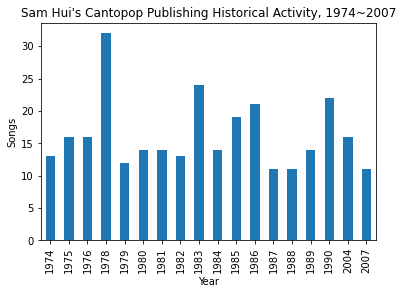

In [712]:
PivotDFinal.plot.bar(title="Sam Hui's Cantopop Publishing Historical Activity, 1974~2007", ylabel="Songs",legend=False)

It's obvious that we will need to customise our pivot functions in order to gain useful insights.

In [701]:
import matplotlib.pyplot as plt

<h2>Difficulties</h2>
<h3>Lack of Data Verification</h3>

Due to my lack of time for actual historical research, I am unable to fully verify all 292 data entries within the database. 

<h3>Slightly Inconsistent Formatting in Lyrics</h3>

I also had to forfeit the idea of unifying all the background vocals, often denoted by (...) in the lyrics, due to obvious time constraints.

<h3>Imperfect Data Sources</h3>

Crowd-sourced data sources like KKBox.com and Mojim.com are unreliable in nature.

While Musicbrainz (https://musicbrainz.org/artist/36ef3857-5be4-4ee0-9e8b-3280a9913a67) might be somewhat more complete for some information, its complexity deterred me from trying to scrape it for this project, instead only manually cross-referencing it for data verification.

<h3>Insufficient Organisation</h3>

Preferably I would have intentionally ordered all the names, but due to time constraints I will mostly have to leave this to the default ordering. That being said, I suppose that the default order is soemwhat indicative of each name's significance in the composition.

<h2>Biases</h2>
<h3>Omission of Musical Components</h3>

This limits my discussion on Sam Hui's musical style from a musical standpoint.

<h3>Omission of Contextual Data</h3>

This limits the potential in drawing connections between Sam Hui, his associates, his works, and the historical context.

<h3>Lack of Popularity Statistics</h3>

This limits my analysis on reasons contributing to his shifts in styles.

<h2>References</h2>

Sam Hui. (2011). 許冠傑 音樂大全101 [Album]. Universal musics Ltd.

我愛你アイ・ラブ・ユー (https://www.youtube.com/watch?v=2iHA_o2iK4w), (https://www.youtube.com/watch?v=pcOqc3uTgLg), (https://ja.wikipedia.org/wiki/皇帝密使).

Top Secret (https://www.nicovideo.jp/watch/sm29443990).